In [1]:
!ls ../data

borsa  borsa2  fuori_casa  taratura


## Parameters Federico's camera
1 SIMPLE_RADIAL 3840 2160 3573.15 1920 1080 0.0466929

In [18]:
import numpy as np
import collections
import struct
import transforms3d.quaternions as quat
from pathlib import PosixPath

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [19]:
camera_file = PosixPath('../data/borsa/model/sparse/0/cameras.bin')
image_file = PosixPath('../data/borsa/model/sparse/0/images.bin')
points_file = PosixPath('../data/borsa/model/sparse/0/points3D.bin')

In [20]:
def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)


def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi")
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":   # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8,
                                           format_char_sequence="Q")[0]
            x_y_id_s = read_next_bytes(fid, num_bytes=24*num_points2D,
                                       format_char_sequence="ddq"*num_points2D)
            xys = np.column_stack([tuple(map(float, x_y_id_s[0::3])),
                                   tuple(map(float, x_y_id_s[1::3]))])
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_id] = Image(
                id=image_id, qvec=qvec, tvec=tvec,
                camera_id=camera_id, name=image_name,
                xys=xys, point3D_ids=point3D_ids)
    return images

In [21]:
images = list(read_images_binary(image_file).values())

In [22]:
images.sort(key=lambda x: int(x.name[3:-4]))
names = list(map(lambda x: int(x.name[3:-4]), images))
tvecs = np.array(list(map(lambda x: x.tvec, images)))
qvecs = np.array(list(map(lambda x: x.qvec, images)))

In [23]:
xyz_positions = []

for i in range(len(qvecs)):
    R = quat.quat2mat(qvecs[i])
    xyz_positions.append(np.dot(-(R.T), tvecs[i]))
xyz_positions = np.array(xyz_positions, dtype=np.float32)

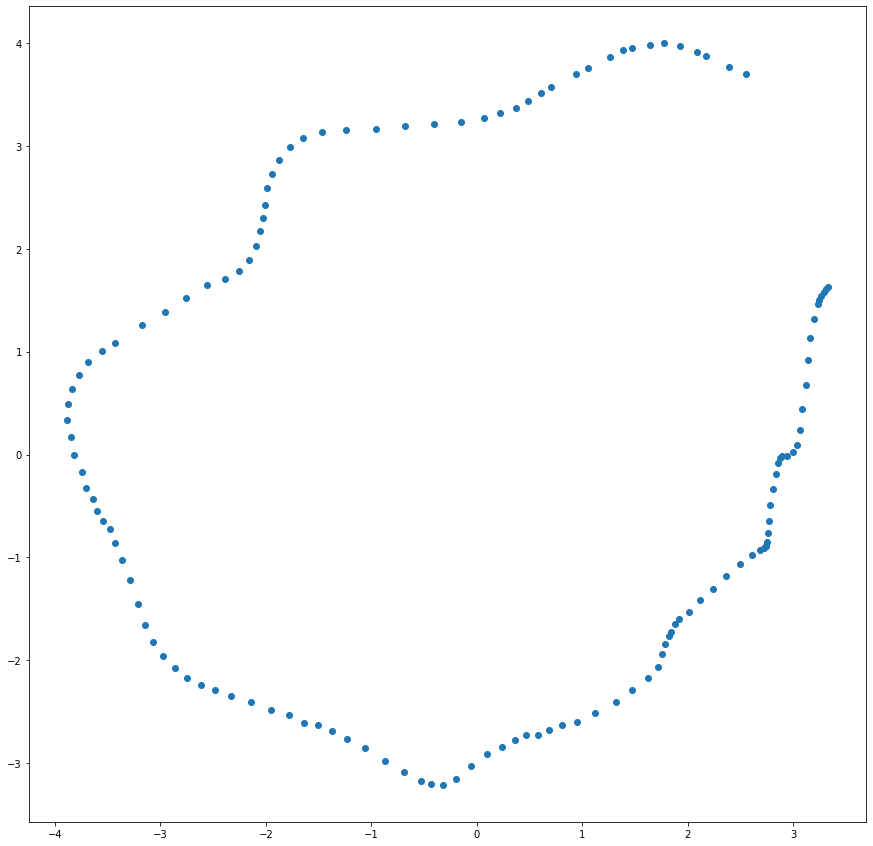

In [24]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes()
ax.scatter(xyz_positions[:,0], xyz_positions[:,1])